In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor, early_stopping

from sklearn.inspection import permutation_importance
import shap

import warnings
warnings.filterwarnings("ignore")

# Анализ значимости признаков

Возьмем лучшие гиперпараметры, обучим модель на всей тренировочной выборке и проанализируем значимость признаков (лучшая модель - наименее переобученная, то есть модель LGBM с параметрами lgbm_5_params):

In [3]:
best_params = {
    'random_state': 42,
    'verbose': -1,
    'n_estimators': 1000,
    'objective': 'mae',
    'learning_rate': 0.005483200175064182,
    'num_leaves': 22,
    'max_depth': 8,
    'max_bin': 170,
    'min_child_samples': 600,
    'min_split_gain': 0.9,
    'subsample': 0.8104803788268242,
    'subsample_freq': 2,
    'colsample_bytree': 0.9987695679080075,
    'reg_alpha': 44,
    'reg_lambda': 2
}

In [5]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [6]:
X_test, y_test = test.drop(['p_num', 'target'], axis=1), test['target']
X_train, y_train = train.drop(['p_num', 'target'], axis=1), train['target']

In [7]:
model = LGBMRegressor(**best_params)
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9987695679080075,
              learning_rate=0.005483200175064182, max_bin=170, max_depth=8,
              min_child_samples=600, min_split_gain=0.9, n_estimators=1000,
              num_leaves=22, objective='mae', random_state=42, reg_alpha=44,
              reg_lambda=2, subsample=0.8104803788268242, subsample_freq=2,
              verbose=-1)

## Permutation Importance

In [8]:
# Permutation Importance
perm = permutation_importance(model,
                              X_test,
                              y_test,
                              random_state=42,
                              n_repeats=5)
perm_df = pd.DataFrame({
    'feature': list(X_test.columns),
    'value': perm['importances_mean']
}).sort_values(by='value', ascending=False)

In [9]:
perm_df.head()

,feature,value
71,bg_0_00,1.284726
360,hour,0.010624
68,bg_0_15,0.009384
65,bg_0_30,0.007621
69,bg_0_10,0.003784


Text(0.5, 1.0, 'Значимость признаков (Permutation importance)')

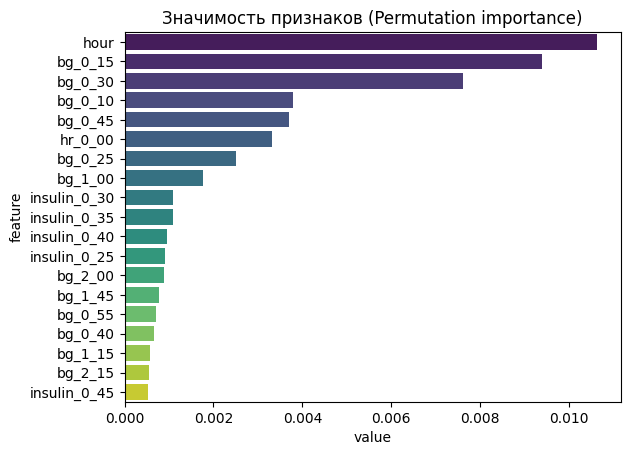

In [10]:
plt.figure()
sns.barplot(data=perm_df[1:20], x='value', y='feature', palette='viridis')
plt.title('Значимость признаков (Permutation importance)')

   По permutation importance самым важным признаком оказался самый последний (самый "свежий") показатель уровня глюкозы (bg-0:00), второй по значимости признак - час дня hour, далее идут наиболее недавние значения уровня глюкозы (за последний час), самый "свежий" показатель частоты сердечных сердцебиений hr-0:00, значения уровня инсулина за последний час и значения уровня глюкозы за последние два часа.

## Shap Values

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

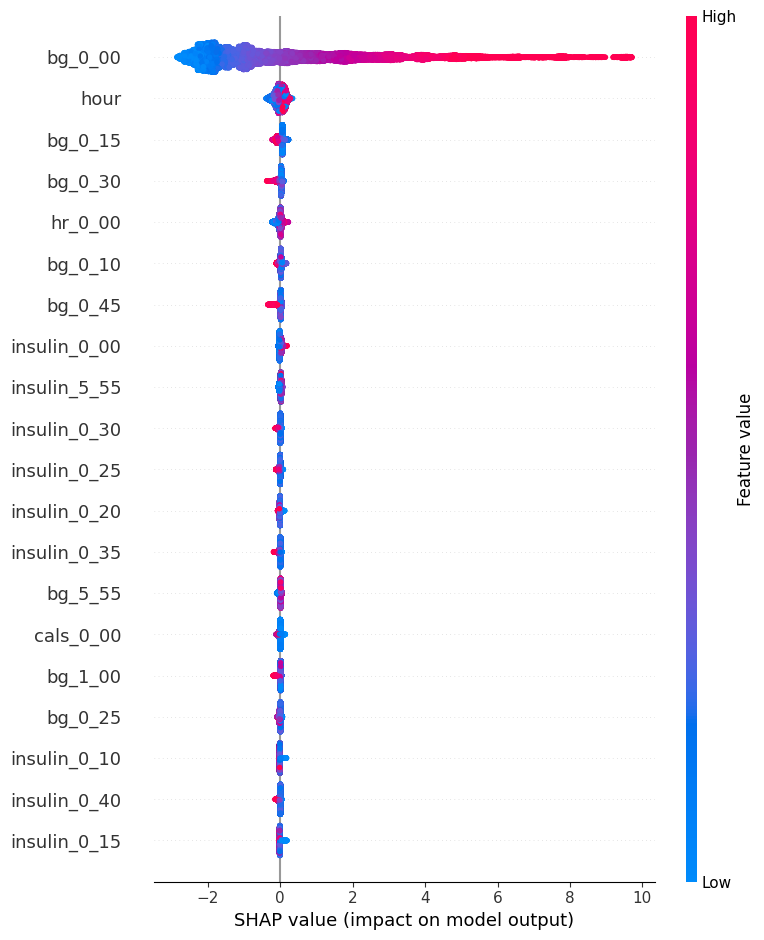

In [12]:
shap.summary_plot(shap_values, X_test)

   С shap values картина примерно такая же, как с permutation importance, однако есть несколько отличий: по shap values важным признаком оказался так же признак cals-0:00 (количество калорий, сожженных за последние 5 минут), а также почему-то уровень инсулина и глюкозы 6 часов назад (insulin-5:55 и bg-5:55).

# Выводы(общие для permutation importance и shap)

- Самым важным признаком для модели оказался последний показатель уровня глюкозы в крови(за час до момента предсказания), что достаточно логично, так как это наиболее близкое по времени значение к уровню глюкозы через час в будущем
- Час суток оказался вторым по значимости признаком, что скорее всего отражает циркадные биоритмы, а также распорядок дня участников исследования(то, в какое время они обычно принимают пищу, вводят инсулин)
- Среди наиболее значимых признаков превалируют показатели уровня глюкозы и инсулина за последние два часа
- Значимым признаком оказалась частота сердечных сердцебиений за час до момента предсказания